# 02_hsn_v1_lean-adp

In [1]:
import time
import skimage.io as imgio
import pandas as pd
import numpy.matlib

from adp_cues import ADPCues
from utilities import *
from dataset import Dataset

MODEL_CNN_ROOT = '../database/models_cnn'
MODEL_WSSS_ROOT = '../database/models_wsss'

Using TensorFlow backend.


In [2]:
dataset = 'ADP'
model_type = 'VGG16'
batch_size = 16
set_name = 'segtest'
sess_id = dataset + '_' + model_type
if model_type in ['VGG16', 'VGG16bg']:
    size = 321
else:
    size = 224
should_saveimg = False
is_verbose = True

## Load Grad-CAM weights

In [3]:
ac = ADPCues(sess_id, batch_size, size, model_dir=MODEL_CNN_ROOT)
OVERLAY_R = 0.75

# Load network and thresholds
ac.build_model()

# Load images
if is_verbose:
    print('\tGetting Grad-CAM weights for given network')
alpha = ac.get_grad_cam_weights(np.zeros((1, size, size, 3)))

# Read in image names
img_names = ac.get_img_names(set_name)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
	Getting Grad-CAM weights for given network
Instructions for updating:
Use tf.cast instead.


## Generate segmentations for single batch

In [4]:
# Process images in batches
confusion_matrix = {}
gt_count = {}
out_dirs = {}
for htt_class in ['morph', 'func']:
    confusion_matrix[htt_class] = np.zeros((len(ac.classes['valid_' + htt_class]), len(ac.classes['valid_' + htt_class])))
    gt_count[htt_class] = np.zeros((len(ac.classes['valid_' + htt_class])))
    out_dirs[htt_class] = os.path.join('out', 'ADP-' + htt_class + '_' + set_name + '_' + model_type)
    if not os.path.exists(out_dirs[htt_class]):
        os.makedirs(out_dirs[htt_class])
n_batches = 1 # len(img_names) // batch_size + 1
for iter_batch in range(n_batches):
    batch_start_time = time.time()
    print('\tBatch #%d of %d' % (iter_batch + 1, n_batches))
    start_idx = iter_batch * batch_size
    end_idx = min(start_idx + batch_size - 1, len(img_names) - 1)
    cur_batch_sz = end_idx - start_idx + 1

    # Image reading
    start_time = time.time()
    img_batch_norm, img_batch = ac.read_batch(img_names[start_idx:end_idx + 1])
    print('\t\tImage read time: %0.5f seconds (%0.5f seconds / image)' % (
    time.time() - start_time, (time.time() - start_time) / cur_batch_sz))

    # Generate patch confidence scores
    start_time = time.time()
    predicted_scores = ac.model.predict(img_batch_norm)
    is_pass_threshold = np.greater_equal(predicted_scores, ac.thresholds)
    print('\t\tGenerating patch confidence scores time: %0.5f seconds (%0.5f seconds / image)' % (
    time.time() - start_time, (time.time() - start_time) / cur_batch_sz))

    # Generate Grad-CAM
    start_time = time.time()
    H = grad_cam(ac.model, alpha, img_batch_norm, is_pass_threshold, ac.final_layer, predicted_scores,
                 orig_sz=[size, size], should_upsample=True)
    H = np.transpose(H, (0, 3, 1, 2))
    # Split Grad-CAM into {morph, func}
    H_split = {}
    H_split['morph'], H_split['func'] = split_by_httclass(H, ac.classes['all'], ac.classes['morph'], ac.classes['func'])
    is_pass = {}
    is_pass['morph'], is_pass['func'] = split_by_httclass(is_pass_threshold, ac.classes['all'], ac.classes['morph'], ac.classes['func'])
    print('\t\tGenerating Grad-CAM time: %0.5f seconds (%0.5f seconds / image)' % (
    time.time() - start_time, (time.time() - start_time) / cur_batch_sz))

    # Modify Grad-CAM for each HTT type separately
    Y_gradcam = {}
    Y_csgc = {}
    Y_crf = {}
    for htt_class in ['morph', 'func']:
        Y_gradcam[htt_class] = np.zeros((cur_batch_sz, len(ac.classes['valid_' + htt_class]), size, size))
        Y_gradcam[htt_class][:, ac.classinds[htt_class + '2valid']] = H[:, ac.classinds['all2' + htt_class]]

        # Inter-HTT Adjustments
        start_time = time.time()
        if htt_class == 'morph':
            Y_gradcam[htt_class] = modify_by_htt(Y_gradcam[htt_class], img_batch, ac.classes['valid_' + htt_class])
        elif htt_class == 'func':
            adipose_inds = [i for i, x in enumerate(ac.classes['morph']) if x in ['A.W', 'A.B', 'A.M']]
            gradcam_adipose = Y_gradcam['morph'][:, adipose_inds]
            Y_gradcam[htt_class] = modify_by_htt(Y_gradcam[htt_class], img_batch, ac.classes['valid_' + htt_class],
                                                 gradcam_adipose=gradcam_adipose)
        Y_csgc[htt_class] = get_cs_gradcam(Y_gradcam[htt_class], ac.classes['valid_' + htt_class], htt_class)
        print('\t\t\tInter-HTT adjustments time [%s]: %0.5f seconds (%0.5f seconds / image)' % (htt_class,
        time.time() - start_time, (time.time() - start_time) / cur_batch_sz))

        # FC-CRF
        start_time = time.time()
        dcrf_config = np.load(os.path.join(MODEL_WSSS_ROOT, htt_class + '_optimal_pcc.npy'))[0]
        Y_crf[htt_class] = dcrf_process(Y_csgc[htt_class], img_batch, dcrf_config)
        print('\t\t\tCRF time [%s]: %0.5f seconds (%0.5f seconds / image)' % (htt_class,
        time.time() - start_time, (time.time() - start_time) / cur_batch_sz))

        # Update evaluation performance
        _, gt_batch = read_batch(os.path.join(ac.gt_root, 'ADP-' + htt_class), img_names[start_idx:end_idx + 1], cur_batch_sz,
                                 [1088, 1088], 'ADP')
        for iter_img in range(cur_batch_sz):
            pred_idx = cv2.resize(Y_crf[htt_class][iter_img], dsize=(1088, 1088), interpolation=cv2.INTER_NEAREST)
            gt_r = gt_batch[iter_img][:, :, 0]
            gt_g = gt_batch[iter_img][:, :, 1]
            gt_b = gt_batch[iter_img][:, :, 2]
            pred_segmask = np.zeros((1088, 1088, 3))
            for k, gt_colour in enumerate(ac.colours[htt_class]):
                gt_mask = (gt_r == gt_colour[0]) & (gt_g == gt_colour[1]) & (gt_b == gt_colour[2])
                pred_mask = pred_idx == k
                confusion_matrix[htt_class][k, :] += np.bincount(pred_idx[gt_mask],
                                                                 minlength=len(ac.classes['valid_' + htt_class]))
                ac.intersects[htt_class][k] += np.sum(gt_mask & pred_mask)
                ac.unions[htt_class][k] += np.sum(gt_mask | pred_mask)
                pred_segmask += np.expand_dims(pred_mask, axis=2) * \
                                np.expand_dims(np.expand_dims(ac.colours[htt_class][k], axis=0), axis=0)
                gt_count[htt_class][k] += np.sum(gt_mask)
            if should_saveimg:
                orig_filepath = os.path.join(ac.img_dir, img_names[start_idx + iter_img])
                orig_img = cv2.cvtColor(cv2.imread(orig_filepath), cv2.COLOR_RGB2BGR)
                pred_segmask_small = cv2.resize(pred_segmask, (orig_img.shape[0], orig_img.shape[1]),
                                                interpolation=cv2.INTER_NEAREST)
                imgio.imsave(
                    os.path.join(out_dirs[htt_class], img_names[start_idx + iter_img].replace('.png', '') + '.png'),
                    pred_segmask_small / 256.0)
                imgio.imsave(os.path.join(out_dirs[htt_class],
                                          img_names[start_idx + iter_img].replace('.png', '') + '_overlay.png'),
                             (1 - OVERLAY_R) * orig_img / 256.0 +
                             OVERLAY_R * pred_segmask_small / 256.0)
    elapsed_time = time.time() - batch_start_time
    print('\tElapsed time: %0.5f seconds (%0.5f seconds / image)' % (elapsed_time, elapsed_time / cur_batch_sz))

	Batch #1 of 1
		Image read time: 0.94042 seconds (0.05878 seconds / image)
		Generating patch confidence scores time: 13.47637 seconds (0.84227 seconds / image)
		Generating Grad-CAM time: 16.81824 seconds (1.05114 seconds / image)
			Inter-HTT adjustments time [morph]: 2.00019 seconds (0.12501 seconds / image)
			CRF time [morph]: 5.01705 seconds (0.31357 seconds / image)
			Inter-HTT adjustments time [func]: 0.50176 seconds (0.03136 seconds / image)
			CRF time [func]: 7.35867 seconds (0.45992 seconds / image)
	Elapsed time: 67.52247 seconds (4.22015 seconds / image)


## Show sample segmentations

### Morphological Types

In [12]:
I = cv2.cvtColor(cv2.imread(os.path.join(ac.img_dir, img_names[0])), cv2.COLOR_RGB2BGR)
_, G = read_batch(os.path.join(ac.gt_root, 'ADP-morph'), [img_names[0]], 1, [1088, 1088], 'ADP')
Y_gradcam_morph = maxconf_class_as_colour(np.argmax(Y_gradcam['morph'], axis=1), ac.colours['morph'], [321, 321])[0]
Y_csgc_morph = maxconf_class_as_colour(np.argmax(Y_csgc['morph'], axis=1), ac.colours['morph'], [321, 321])[0]
Y_crf_morph = maxconf_class_as_colour(Y_crf['morph'], ac.colours['morph'], [321, 321])[0]

Text(0.5, 1.0, 'Morphological\n ground truth')

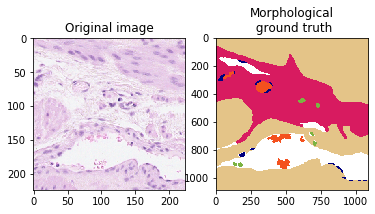

In [14]:
plt.figure
plt.subplot(121)
plt.imshow(I.astype('uint8'))
plt.title('Original image')
plt.subplot(122)
plt.imshow(G[0].astype('uint8'))
plt.title('Morphological\n ground truth')

Text(0.5, 1.0, 'Post-CRF')

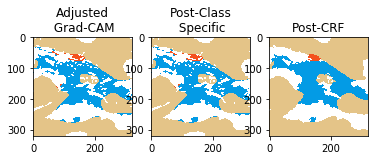

In [17]:
plt.figure
plt.subplot(131)
plt.imshow(Y_gradcam_morph.astype('uint8'))
plt.title('Adjusted\n Grad-CAM')
plt.subplot(132)
plt.imshow(Y_csgc_morph.astype('uint8'))
plt.title('Post-Class\n Specific')
plt.subplot(133)
plt.imshow(Y_crf_morph.astype('uint8'))
plt.title('Post-CRF')

### Functional Types

In [18]:
_, G = read_batch(os.path.join(ac.gt_root, 'ADP-func'), [img_names[0]], 1, [1088, 1088], 'ADP')
Y_gradcam_func = maxconf_class_as_colour(np.argmax(Y_gradcam['func'], axis=1), ac.colours['func'], [321, 321])[0]
Y_csgc_func = maxconf_class_as_colour(np.argmax(Y_csgc['func'], axis=1), ac.colours['func'], [321, 321])[0]
Y_crf_func = maxconf_class_as_colour(Y_crf['func'], ac.colours['func'], [321, 321])[0]

Text(0.5, 1.0, 'Functional\n ground truth')

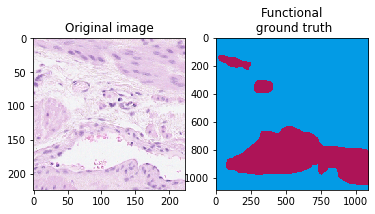

In [19]:
plt.figure
plt.subplot(121)
plt.imshow(I.astype('uint8'))
plt.title('Original image')
plt.subplot(122)
plt.imshow(G[0].astype('uint8'))
plt.title('Functional\n ground truth')

Text(0.5, 1.0, 'Post-CRF')

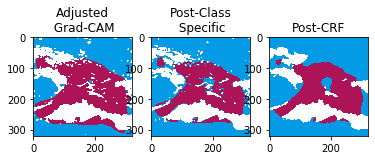

In [20]:
plt.figure
plt.subplot(131)
plt.imshow(Y_gradcam_func.astype('uint8'))
plt.title('Adjusted\n Grad-CAM')
plt.subplot(132)
plt.imshow(Y_csgc_func.astype('uint8'))
plt.title('Post-Class\n Specific')
plt.subplot(133)
plt.imshow(Y_crf_func.astype('uint8'))
plt.title('Post-CRF')